# Collaborative Filtering: Top-$k$ Filtering

## Alex Riley, Apr 23 2018

Thus far, we've looked at weighting user ratings by Pearson correlation coefficient and Cosine similarity.  Here we introduce another concept: top-$k$ filtering.  This is very similar to the prior methods but instead of weighting all users, we only consider the $k$ users most-like our user of interest.

## Load/split data, compute weights

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *

# to supress divide by zero or NaN errors that are handled
ignore = np.seterr(divide='ignore', invalid='ignore')

In [2]:
flat_ratings = pd.read_csv('data/ratings.csv',header=0)
ratings_p = flat_ratings.pivot_table(index='userId',columns='movieId',values='rating')

We'll split this into training and test sets, like usual

In [3]:
train_p, test_p = train_test_split(ratings_p, empty=np.nan, testfrac=0.2)

Note that it will be useful to have two versions of the dataframes running around
* Pearson: empty cells filled with NaNs
* Cosine: empty cells filled with 0.0s

In [4]:
ratings_c = ratings_p.fillna(value=0.0)
train_c = train_p.fillna(value=0.0)
test_c = test_p.fillna(value=0.0)

Since the weights will not change with changing $k$, we can also compute those for each method

In [5]:
weights_p = train_p.transpose().corr()
weights_c = cosine_sim(train_c)

## Top-$k$ Filtering

In [6]:
def predict_topk(rates, weights, k=40):
    weights = np.nan_to_num(weights)
    vals = rates.values
    pred = np.zeros(vals.shape)
    mask = rates.mask(rates>0, other=1.0).values
    for i in range(vals.shape[0]):
        row = weights[:,i]
        row[np.isnan(row)] = -np.inf
        
        # indices of high-weight users, not counting self, descending
        topk_users = [np.argsort(row)[-2:-k-2:-1]]
        topk_weights = row[topk_users]
        sumweights = np.abs(topk_weights).dot(mask[topk_users])
        pred[i] = topk_weights.dot(vals[topk_users])/sumweights
    
    return pd.DataFrame(data=pred, index=rates.index, columns=rates.columns)

We compute the top-$k$ filtered results for both the Pearson coefficient weighting and Cosine similarity weighting

In [7]:
pred_p = predict_topk(train_c, weights_p.values)
pred_c = predict_topk(train_c, weights_c)

As before, we can find the MSE of our predictions

In [8]:
print("Top-k Pearson MSE: " + str(mse(pred_p.fillna(0.), test_c)))
print("Top-k Cosine MSE: " + str(mse(pred_c, test_c)))

Top-k Pearson MSE: 7.863174820396934
Top-k Cosine MSE: 0.9806450923499717


## Tuning $k$

We can plot MSE as a function of $k$ in order to see what the optimum $k$ should be for minimizing the MSE.  For Cosine similarity

In [9]:
kvals = [5,10,20,30,50,100,200,300,400,500,600]
train_c_mse, test_c_mse = [], []

for k in kvals:
    predict_k = predict_topk(train_c, weights_c, k=k)
    train_c_mse.append(mse(predict_k, actual=train_c))
    test_c_mse.append(mse(predict_k, actual=test_c))

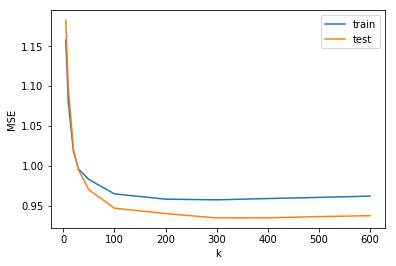

In [10]:
plt.plot(kvals, train_c_mse, label='train')
plt.plot(kvals, test_c_mse, label='test')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend(loc='best');

Optimum k: 300
MSE for k_opt: 0.9345761933959383


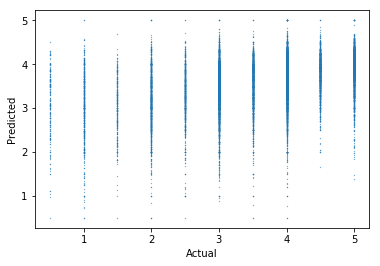

In [11]:
kopt_c = kvals[np.argmin(test_c_mse)]
pred_kopt_c = predict_topk(train_c, weights_c, k=kopt_c)

print("Optimum k: " + str(kopt_c))
print("MSE for k_opt: " + str(test_c_mse[np.argmin(test_c_mse)]))

plt.plot(test_c.values[test_c.values > 0], pred_kopt_c.values[test_c.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

We still see a smear across parameter space, but theres a reduction in the MSE from ~0.98 to ~0.93 for only considering the top 300 users with Cosine similarity.

In [12]:
### For Pearson similarity
train_p_mse, test_p_mse = [], []
for k in kvals:
    predict_k = predict_topk(train_c, weights_p.values, k=k)
    train_p_mse.append(mse(predict_k.fillna(0), actual=train_c))
    test_p_mse.append(mse(predict_k.fillna(0), actual=test_c))

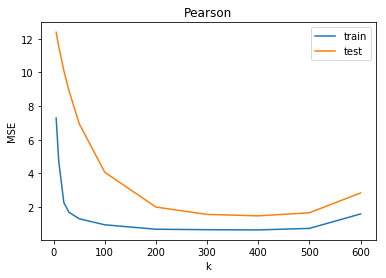

In [13]:
plt.plot(kvals, train_p_mse, label='train')
plt.plot(kvals, test_p_mse, label='test')
plt.title('Pearson')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend(loc='best');

Yeah, the top k clearly didn't work with the Pearson similarity...

Optimum k: 400
MSE for k_opt: 1.4764580832914556


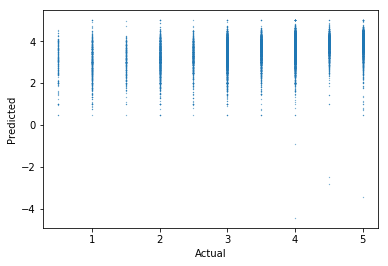

In [14]:
kopt_p = kvals[np.argmin(test_p_mse)]
pred_kopt_p = predict_topk(train_c, weights_p.values, k=kopt_p)

print("Optimum k: " + str(kopt_p))
print("MSE for k_opt: " + str(test_p_mse[np.argmin(test_p_mse)]))

plt.plot(test_p.values[test_p.values > 0], pred_kopt_p.values[test_p.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

Again, the results for Pearson similarity are very similar, though there's a much steeper fall-off as you increase the k in low-digits from Pearson than there is in Cosine similarity. Interestingly, here the MSE for Cosine is much smaller than Pearson (0.93 vs. 1.47).

## Final note on computation

The results in this notebook are for taking the top-$k$ similar users and computing the ratings using only those users *independent of whether those k users actually performed a rating*.  To do the top-$k$ users per user, per movie would get much more computationally challenging.  Here alone there was a relatively small large change in computing time when computing top-$k$ (~30 seconds, linearly dependent on $k$) and simply using the full ratings matrix (~1 second).  For more users, one is probably better off sticking with the full matrix and keeping the computational efficiency.